# DS15 Lecture Topic Modeling
## IMBD Movie Reviews

## Guiding Question
What are commons these in movies that people liked?

## Approach
* Apply NLP to movie reviews
* Estimate a topic model on the movie reviews
* Create visualizations relating the topics to the review scores

https://www.youtube.com/watch?v=OsF6Y5Xs4Mc&feature=youtu.be

In [2]:
import zipfile
with zipfile.ZipFile("./134715_320111_bundle_archive.zip", "r") as zip_ref:
    zip_ref.extractall("./data/")

In [3]:
import pandas as pd

df = pd.read_csv('./data/IMDB Dataset.csv')

In [4]:
df.shape

(50000, 2)

In [5]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
# Remove html tags
df['review'] = df['review'].apply(lambda x: x.replace('<br />', ''))

In [7]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. The filming tec...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


# Applying NLP
* We need to tokenize the text
* How should we do it?
- Use Spacy
- Figure our what our unit of analysis (lemmas, adj, keywords, nouns, spacy tokens, etc.) Try different ones
- Keyword extraction NEW TECHNIQUE

In [8]:
import spacy

nlp = spacy.load('en_core_web_lg')

In [45]:
# Try Lemmatization as our first Experiment

def get_lemmas(text):
    
    lemmas = []
    
    doc = nlp(text)
    
    STOP_WORDS = nlp.Defaults.stop_words.union(["film", "movie", "character", "actor"])
    
    for token in doc:
        conditions = (token.is_stop == False) and (token.is_punct == False) and (token.pos_ != 'PRON') and (token.text not in STOP_WORDS)
        if conditions:
            lemmas.append(token.lemma_)
    
    return lemmas

In [46]:
from tqdm import tqdm
tqdm.pandas()

In [47]:
df['lemmas'] = df['review'].progress_apply(get_lemmas)

100%|██████████| 50000/50000 [22:16<00:00, 37.41it/s]


## Topic Modeling w/ Gensim
* Learn a Vocabulary
* Create a Bag of Words (BoW) representation of each document
* Estimate our LDA model
* Clean up the results
* Add topic information back to dataframe

In [48]:
import gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

In [49]:
# like countVectorizer fit

id2word = corpora.Dictionary(df['lemmas'])

In [50]:
# for statistical trimming
id2word.filter_extremes(no_below=50, no_above=.90)

In [51]:
#how big is corpus
len(id2word.keys())

8510

In [52]:
id2word[0]

'1'

In [53]:
# Transform

corpus = [id2word.doc2bow(doc) for doc in df['lemmas']]

In [54]:
df.head()

,review,sentiment,lemmas
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, 1, Oz, episode, hoo..."
1,A wonderful little production. The filming tec...,positive,"[wonderful, little, production, filming, techn..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, Jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, love, Time, money, visually, ..."


In [55]:
# the key to LDA is in the preprocessing than it is in the modeling

lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   num_topics = 5, # 15 to 5
                   passes=100, # 2 to 15, usually 100 to get better results
                   workers=12,
                   random_state=812)

# parameter to tune are
#.num_topics
#.passes

# need more passes
# need more stop words
# need statical trimming see id2word

# look up coherence scores

In [56]:
lda.print_topics()

[(0,
  '0.021*"bad" + 0.019*"like" + 0.014*"watch" + 0.011*"good" + 0.011*"think" + 0.010*"time" + 0.010*"see" + 0.008*"look" + 0.008*"movie" + 0.007*"know"'),
 (1,
  '0.023*"good" + 0.015*"great" + 0.014*"like" + 0.010*"watch" + 0.009*"see" + 0.009*"time" + 0.009*"funny" + 0.009*"comedy" + 0.009*"love" + 0.008*"think"'),
 (2,
  '0.010*"horror" + 0.009*"scene" + 0.006*"like" + 0.005*"kill" + 0.005*"plot" + 0.005*"film" + 0.005*"look" + 0.004*"good" + 0.004*"end" + 0.004*"man"'),
 (3,
  '0.009*"play" + 0.006*"man" + 0.005*"good" + 0.005*"year" + 0.004*"role" + 0.004*"time" + 0.004*"star" + 0.003*"scene" + 0.003*"performance" + 0.003*"John"'),
 (4,
  '0.011*"story" + 0.009*"life" + 0.007*"time" + 0.007*"people" + 0.007*"like" + 0.006*"love" + 0.005*"way" + 0.005*"character" + 0.005*"see" + 0.005*"find"')]

In [57]:
import re

words = [re.findall(r'"([^"]*)"', t[1]) for t in lda.print_topics()]

In [58]:
topics = [' '.join(t[0:5]) for t in words]

In [59]:
for id, t in enumerate(topics):
    print(f"------- Topic {id} -------")
    print(t, end="\n\n")

------- Topic 0 -------
bad like watch good think

------- Topic 1 -------
good great like watch see

------- Topic 2 -------
horror scene like kill plot

------- Topic 3 -------
play man good year role

------- Topic 4 -------
story life time people like



## Analyzing the Results of LDA
- How good are the topics themselves?
    * Using tntertopic distance visualization
    * Looking at some of the tokens distributions
- Using the LDA topics for analysis:
    * Score each review with a top topic
    * Summary visualization of top topic versus sentiment

In [60]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [62]:
pyLDAvis.gensim.prepare(lda, corpus, id2word)

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.139082  0.026719       1        1  24.568437
4     -0.042569  0.008977       2        1  24.403752
3     -0.149075 -0.045232       3        1  17.330081
1      0.068966 -0.116207       4        1  17.171682
2     -0.016404  0.125743       5        1  16.526048, topic_info=       Term          Freq         Total Category  logprob  loglift
389     bad  26010.000000  26010.000000  Default  30.0000  30.0000
99    watch  27631.000000  27631.000000  Default  29.0000  29.0000
501  horror   7163.000000   7163.000000  Default  28.0000  28.0000
267    good  40407.000000  40407.000000  Default  27.0000  27.0000
107  comedy   7131.000000   7131.000000  Default  26.0000  26.0000
..      ...           ...           ...      ...      ...      ...
91    thing   2204.710842  16325.816504   Topic5  -5.7959  -0.2019
143    time   2226.674059  30847.406280   Topic5  -5.7860  -0.8283
304    work   2003.370603  13683.670495   Topic5  -5.8917  -0.1211
106    come   1988.722773  16440.973324   Topic5  -5.8990  -0.3121
480     try   1915.282517  12439.908360   Topic5  -5.9366  -0.0708

[478 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6189      1  0.995709       0
0         1  0.873605       1
0         2  0.030082       1
0         3  0.021428       1
0         4  0.069229       1
...     ...       ...     ...
239       1  0.000585  zombie
239       5  0.998974  zombie
3568      2  0.211724       
3568      3  0.240997       
3568      5  0.546955       

[1103 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 3])

### Label Our Review with the most common topic

In [63]:
doc_topics = [lda[doc] for doc in corpus]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [64]:
doc_topics[0]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, 0.10967667), (2, 0.4321646), (3, 0.10245323), (4, 0.35401234)]

In [66]:
def update(doc):
    d_dist = {k:0 for k in range(0,5)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

new_distro = [update(d) for d in doc_topics]

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
dft = pd.DataFrame.from_records(new_distro)
dft.columns = topics

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
dft.head()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,bad like watch good think,good great like watch see,horror scene like kill plot,play man good year role,story life time people like
0,0.109677,0.000000,0.432165,0.102453,0.354012
1,0.000000,0.230797,0.000000,0.142290,0.620680
2,0.000000,0.615564,0.191889,0.000000,0.186634
3,0.288021,0.000000,0.357420,0.000000,0.346763
4,0.000000,0.000000,0.000000,0.299105,0.690071


In [69]:
df['primary_topic'] = dft.idxmax(axis=1)

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
df.head()

/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,review,sentiment,lemmas,primary_topic
0,One of the other reviewers has mentioned that ...,positive,"[reviewer, mention, watch, 1, Oz, episode, hoo...",horror scene like kill plot
1,A wonderful little production. The filming tec...,positive,"[wonderful, little, production, filming, techn...",story life time people like
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ...",good great like watch see
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, Jake, think, ...",horror scene like kill plot
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, love, Time, money, visually, ...",story life time people like


/home/jepoy/miniconda3/envs/ds-unit-4/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'horror scene like kill plot'),
  Text(1, 0, 'story life time people like'),
  Text(2, 0, 'good great like watch see'),
  Text(3, 0, 'bad like watch good think'),
  Text(4, 0, 'play man good year role')])

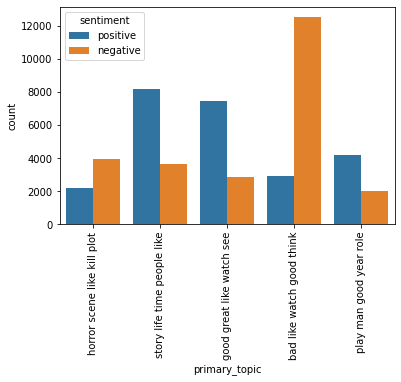

In [72]:
# Simple Bar Graph?
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.countplot(x="primary_topic", hue="sentiment", data=df)
plt.xticks(rotation=90)